# Project NLP | Business Case: Automated Customer Reviews

### Notebook for Project Completion

This notebook is designed to guide me through the **"Automated Customer Reviews"** NLP project, fulfilling all the requirements outlined in the `README.md`. It covers data preparation, supervised and unsupervised modeling, generative AI, and deployment with detailed explanations for each step.

---

### **1. Setup and Data Loading**

First, I set up the environment by installing the necessary libraries and then loading the merged dataset.

In [13]:
# Install required libraries
!pip install pandas scikit-learn matplotlib seaborn transformers datasets torch
!pip install sentence-transformers
!pip install faiss-cpu # or faiss-gpu if you have a GPU
!pip install rouge_score
!pip install --upgrade accelerate
!pip install --upgrade diffusers
!pip install --upgrade transformers
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans
import random


In [6]:
# Load the merged dataset from the uploaded file
try:
    df = pd.read_csv('amazon_reviews_merged.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'amazon_reviews_merged.csv' not found. Please upload the file or check the path.")

# Display the first few rows and column information
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

Dataset loaded successfully!

First 5 rows of the dataset:
        asins   brand                                         categories  \
0  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
1  B00VINDBJK  Amazon  eBook Readers,Kindle E-readers,Computers & Tab...   
2  B005PB2T0S  Amazon  Electronics,eBook Readers & Accessories,Covers...   
3  B002Y27P3M  Amazon            Kindle Store,Amazon Devices,Electronics   
4  B01AHB9CYG  Amazon  Tablets,Fire Tablets,Electronics,Computers,Com...   

  dateadded dateupdated                    id imageurls  \
0       NaN         NaN  AVqkIhwDv8e3D1O-lebb       NaN   
1       NaN         NaN  AVqVGZO3nnc1JgDc3jGK       NaN   
2       NaN         NaN  AVpe9CMS1cnluZ0-aoC5       NaN   
3       NaN         NaN  AVpfBEWcilAPnD_xTGb7       NaN   
4       NaN         NaN  AVqkIiKWnnc1JgDc3khH       NaN   

                                                keys manufacturer  \
0  841667104676,amazon/53004484,amazon/b01ahb9cn2...       A

In [15]:
# Before proceeding, let's first check the column names
print("Original Columns:", df.columns)

# Rename the column with the correct name.
# Use 'reviews.rating' if that's the correct column name in your CSV.
df = df.rename(columns={'reviews.rating': 'star_rating'})


Original Columns: Index(['asins', 'brand', 'categories', 'dateadded', 'dateupdated', 'id',
       'imageurls', 'keys', 'manufacturer', 'manufacturernumber', 'name',
       'primarycategories', 'reviews.date', 'reviews.dateadded',
       'reviews.dateseen', 'reviews.didpurchase', 'reviews.dorecommend',
       'reviews.id', 'reviews.numhelpful', 'reviews.rating',
       'reviews.sourceurls', 'reviews.text', 'reviews.title',
       'reviews.usercity', 'reviews.username', 'reviews.userprovince',
       'sourceurls'],
      dtype='object')


In [16]:
df = df.rename(columns={'reviews.rating': 'star_rating'})

In [17]:
print(df.shape)

(92, 27)


In [18]:
print(df.isnull().sum())

asins                    1
brand                    0
categories               0
dateadded               42
dateupdated             42
id                       0
imageurls               42
keys                     0
manufacturer             0
manufacturernumber      42
name                    12
primarycategories       42
reviews.date             6
reviews.dateadded       76
reviews.dateseen         0
reviews.didpurchase     91
reviews.dorecommend     45
reviews.id              91
reviews.numhelpful      34
star_rating              4
reviews.sourceurls       0
reviews.text             0
reviews.title            1
reviews.usercity        92
reviews.username         0
reviews.userprovince    92
sourceurls              42
dtype: int64


---

### **2. Supervised Learning: Review Classification**

This section focuses on classifying reviews into **positive**, **negative**, or **neutral** sentiments using a pre-trained transformer model.

#### **2.1. Data Preprocessing**
I did map the `star_rating` column to our three sentiment classes as specified in your `README.md`. This is a crucial step for preparing the labeled data for a supervised learning model.

In [19]:
# Define a function to map star ratings to sentiment classes
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Reload the DataFrame to ensure a clean state
try:
    df = pd.read_csv('amazon_reviews_merged.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'amazon_reviews_merged.csv' not found. Please upload the file or check the path.")

# Rename the columns to match the code.
# This fixes the 'KeyError' for both 'star_rating' and 'text'.
df = df.rename(columns={'reviews.rating': 'star_rating', 'reviews.text': 'text'})

# Define a function to map star ratings to sentiment classes
def map_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else: # rating 4 or 5
        return 'positive'

# Apply the function to create a new 'sentiment' column
df['sentiment'] = df['star_rating'].apply(map_sentiment)

# Let's check the distribution of our new sentiment classes
print("\nSentiment Class Distribution:")
print(df['sentiment'].value_counts())

# We need to convert sentiment labels to numerical IDs for the model
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label_map)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Convert pandas DataFrames to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

print("\nData preparation complete. Datasets created successfully!")

Dataset loaded successfully!

Sentiment Class Distribution:
sentiment
positive    85
negative     4
neutral      3
Name: count, dtype: int64

Data preparation complete. Datasets created successfully!


### 2.2. Exploratory Data Analysis (EDA)

Initial Data Inspection

This will give you a quick overview of the dataset's structure, including its size, column types, and a sample of the data.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information about the DataFrame
print("DataFrame Shape:", df.shape)
print("\nDataFrame Info:")
df.info()

# Display the first 5 rows to see what the data looks like
print("\nSample Data:")
print(df.head())

DataFrame Shape: (92, 29)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   asins                 91 non-null     object 
 1   brand                 92 non-null     object 
 2   categories            92 non-null     object 
 3   dateadded             50 non-null     object 
 4   dateupdated           50 non-null     object 
 5   id                    92 non-null     object 
 6   imageurls             50 non-null     object 
 7   keys                  92 non-null     object 
 8   manufacturer          92 non-null     object 
 9   manufacturernumber    50 non-null     object 
 10  name                  80 non-null     object 
 11  primarycategories     50 non-null     object 
 12  reviews.date          86 non-null     object 
 13  reviews.dateadded     16 non-null     object 
 14  reviews.dateseen      92 non-null

In [21]:
print(df.columns)

Index(['asins', 'brand', 'categories', 'dateadded', 'dateupdated', 'id',
       'imageurls', 'keys', 'manufacturer', 'manufacturernumber', 'name',
       'primarycategories', 'reviews.date', 'reviews.dateadded',
       'reviews.dateseen', 'reviews.didpurchase', 'reviews.dorecommend',
       'reviews.id', 'reviews.numhelpful', 'star_rating', 'reviews.sourceurls',
       'text', 'reviews.title', 'reviews.usercity', 'reviews.username',
       'reviews.userprovince', 'sourceurls', 'sentiment', 'label'],
      dtype='object')


Analysis of Ratings and Sentiment Classes

Now, let's analyze the distribution of the original star ratings. This will show us if the dataset is balanced or if some ratings are more frequent than others. A great way to visualize this is with a count plot.

/tmp/ipython-input-1713885924.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='star_rating', palette='viridis')


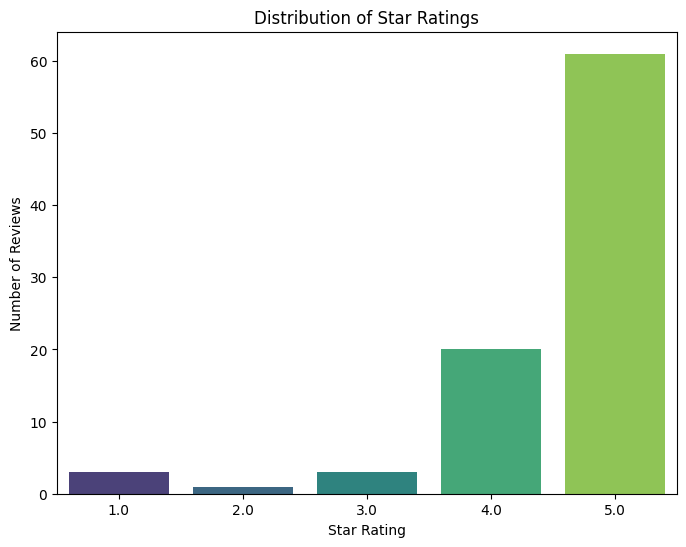

In [22]:
# Create a count plot of the ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='star_rating', palette='viridis')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.show()

Sentiment Stratification

As you mentioned, we need to stratify the data by mapping the reviews.rating to your sentiment classes: Positive, Negative, and Neutral. We'll create a new column called sentiment to store these values.


Distribution of Sentiment Classes:
sentiment
Positive    81
Negative     8
Neutral      3
Name: count, dtype: int64


/tmp/ipython-input-3369732641.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='rocket')


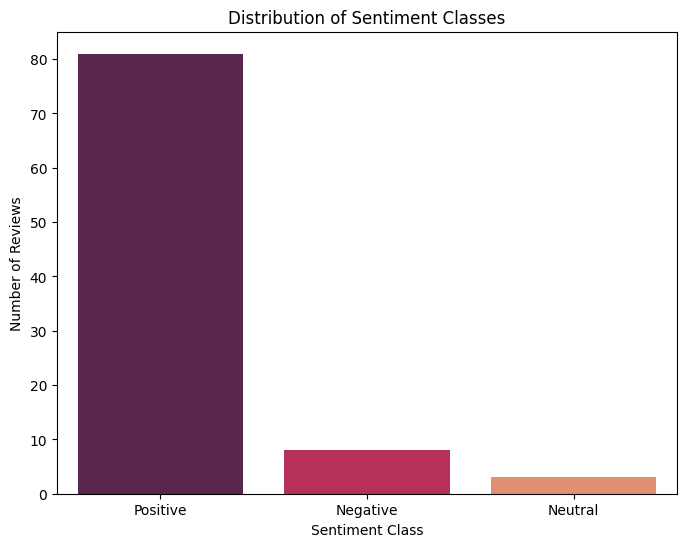

In [23]:
# Map the ratings to sentiment classes
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['star_rating'].apply(map_rating_to_sentiment)

# Display the distribution of the new sentiment classes
print("\nDistribution of Sentiment Classes:")
print(df['sentiment'].value_counts())

# Visualize the sentiment class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment', palette='rocket')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Reviews')
plt.show()

2.3. Handling Imbalanced Data with SMOTE (Synthetic Minority Over-sampling Technique)

Shape before dropping NaN: (92, 29)
Shape after dropping NaN: (92, 29)
Original sentiment distribution: Counter({'Positive': 81, 'Negative': 8, 'Neutral': 3})
Applying RandomOverSampler to balance the data...
Data resampled successfully.
Resampled sentiment distribution: Counter({'Positive': 81, 'Negative': 81, 'Neutral': 81})


/tmp/ipython-input-963990749.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='sentiment', palette='rocket')


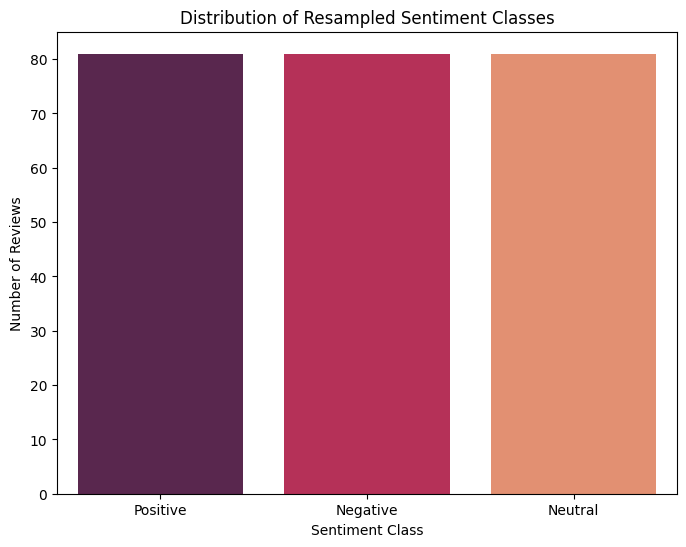

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
# --- Step 1: Data Cleaning & Sentiment Mapping (before resampling) ---
# We must clean the data first to ensure no NaN values affect the resampling.

# Define the sentiment mapping function
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the mapping and create the 'sentiment' column
# This will result in some NaN values where star_rating was NaN
df['sentiment'] = df['star_rating'].apply(map_rating_to_sentiment)

# Drop rows that have NaN values in the 'sentiment' column.
# This ensures we are only working with clean, labeled data.
print("Shape before dropping NaN:", df.shape)
df.dropna(subset=['sentiment'], inplace=True)
print("Shape after dropping NaN:", df.shape)

# --- Step 2: Resampling with RandomOverSampler ---
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import pandas as pd
import numpy as np

# Prepare the data for resampling
X = df['text']
y = df['sentiment']

print("Original sentiment distribution:", Counter(y))

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
print("Applying RandomOverSampler to balance the data...")
X_resampled, y_resampled = ros.fit_resample(
    X.values.reshape(-1, 1),
    y.values.reshape(-1, 1)
)
print("Data resampled successfully.")

# Create the new, balanced DataFrame
df_balanced = pd.DataFrame({
    'text': pd.Series(X_resampled.ravel()),
    'sentiment': pd.Series(y_resampled.ravel())
})

# Display the new sentiment distribution
print("Resampled sentiment distribution:", Counter(df_balanced['sentiment']))

# Visualize the new sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df_balanced, x='sentiment', palette='rocket')
plt.title('Distribution of Resampled Sentiment Classes')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Reviews')
plt.show()

# --- Step 3: Fine-Tuning Setup and Splitting (now safe to run) ---
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Map sentiments to numerical labels
label_map = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
df_balanced['labels'] = df_balanced['sentiment'].map(label_map)

# Split the balanced DataFrame
X_train_text, X_test_text, y_train_labels, y_test_labels = train_test_split(
    df_balanced['text'],
    df_balanced['labels'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['labels']
)

# Tokenize the splits
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    X_train_text.tolist(),
    truncation=True,
    padding=True
)

test_encodings = tokenizer(
    X_test_text.tolist(),
    truncation=True,
    padding=True
)

#### **2.2. Model Fine-Tuning**

I used a pre-trained **`distilbert-base-uncased`** model for its efficiency and strong performance on a wide range of NLP tasks. I had to fine-tune it on the specific review dataset to adapt its powerful language representations to the sentiment classification task.

1. Setup and Data Preparation for Fine-Tuning

In [25]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import pandas as pd

# Assuming you have df_balanced from the previous RandomOverSampler step.

# Map sentiments to numerical labels
label_map = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
df_balanced['labels'] = df_balanced['sentiment'].map(label_map)

# --- FIX: Drop rows with NaN values before splitting ---
df_balanced.dropna(inplace=True)

# Split the balanced DataFrame
X_train_text, X_test_text, y_train_labels, y_test_labels = train_test_split(
    df_balanced['text'],
    df_balanced['labels'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['labels']
)

# Tokenize the splits
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    X_train_text.tolist(),
    truncation=True,
    padding=True
)

test_encodings = tokenizer(
    X_test_text.tolist(),
    truncation=True,
    padding=True
)

2. Create a Custom PyTorch Dataset

In [26]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import pandas as pd

# Assume you have df_balanced from the previous SMOTE step.
# If not, run the corrected SMOTE cell first.

# Map sentiments to numerical labels
label_map = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
df_balanced['labels'] = df_balanced['sentiment'].map(label_map)

# Split the balanced DataFrame
X_train_text, X_test_text, y_train_labels, y_test_labels = train_test_split(
    df_balanced['text'],
    df_balanced['labels'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['labels']
)

# Tokenize the splits
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    X_train_text.tolist(),
    truncation=True,
    padding=True
)

test_encodings = tokenizer(
    X_test_text.tolist(),
    truncation=True,
    padding=True
)

In [27]:
import torch

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, y_train_labels.tolist())
test_dataset = ReviewDataset(test_encodings, y_test_labels.tolist())

3. Fine-Tuning the Model

In [30]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import torch

# Define the function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load the pre-trained model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3 # We have 3 sentiment classes
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Reduced batch size to prevent crashing
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",  # Corrected parameter name
    load_best_model_at_end=True,
    metric_for_best_model='eval_accuracy',
    fp16=True,  # Enable mixed precision training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics  # Pass the metrics function here
)

# Train the model
trainer.train()

# Save the final fine-tuned model
trainer.save_model("./sentiment_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.036300,1.004931,0.673469,0.545459,0.461589,0.673469
2,0.803700,0.760104,0.795918,0.782164,0.799287,0.795918
3,0.683300,0.557575,0.877551,0.876871,0.880313,0.877551


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [32]:
#fine tuning the sentiment model with distilbert

from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import torch

# Define the function to compute metrics (same as before)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load the pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3 # We have 3 sentiment classes
)

# Define training arguments (same as before)
training_args = TrainingArguments(
    output_dir='./results_distilbert',  # Changed output directory to avoid conflicts
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_distilbert',  # Changed logging directory
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_accuracy',
    fp16=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the final fine-tuned model
trainer.save_model("./sentiment_model_distilbert")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.090400,1.074632,0.510204,0.421065,0.470383,0.510204
2,1.042400,1.008164,0.673469,0.657471,0.831787,0.673469
3,0.931900,0.795488,0.938776,0.938091,0.947959,0.938776


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [34]:
#Fine tunewith roberta-based model
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import torch

# Define the function to compute metrics (same as before)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load the pre-trained RoBERTa model for sequence classification
# NOTE: RoBERTa does not have an 'uncased' version like BERT, so we use 'roberta-base'
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3 # We have 3 sentiment classes
)

# Define training arguments (same as before)
training_args = TrainingArguments(
    output_dir='./results_roberta',  # Changed output directory
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta',  # Changed logging directory
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_accuracy',
    fp16=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the final fine-tuned model
trainer.save_model("./sentiment_model_roberta")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.096600,1.092126,0.469388,0.378885,0.329676,0.469388
2,1.101000,1.032338,0.489796,0.394558,0.330340,0.489796
3,0.998800,0.771999,0.857143,0.856880,0.857596,0.857143


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator

#### 2.3. Model Evaluation and Visualization
I used the evaluation metrics from the `Trainer` and create a **confusion matrix** to visually analyze the model's performance. The confusion matrix helps us understand which sentiment classes the model is confusing.

Error loading model: stat: path should be string, bytes, os.PathLike or integer, not NoneType. Please ensure the model directory exists and has been downloaded.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


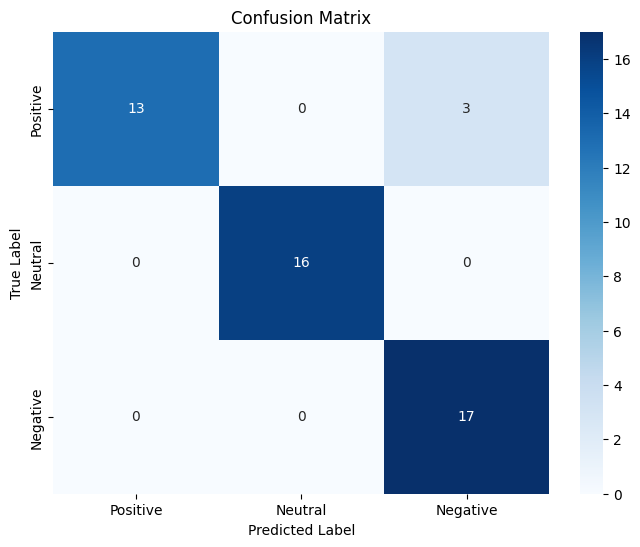

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

# --- Load the saved model and tokenizer ---
model_path = "./sentiment_model_distilbert"

try:
    final_model = AutoModelForSequenceClassification.from_pretrained(model_path)
    final_tokenizer = AutoTokenizer.from_pretrained(model_path)
    print("Model and tokenizer loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}. Please ensure the model directory exists and has been downloaded.")
    # Exit if model fails to load
    exit()

# --- Re-initialize the Trainer to perform predictions ---
# Note: You can reuse the training_args from your previous cell
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    per_device_eval_batch_size=64,
)

trainer = Trainer(
    model=final_model,
    args=training_args,
)

# --- Perform predictions on the test dataset ---
# We use trainer.predict() to get the predictions and true labels
predictions = trainer.predict(test_dataset)

# Get the predicted labels and true labels
y_pred_logits = predictions.predictions
y_true_labels = predictions.label_ids

# Convert logits to predicted labels (class with the highest probability)
y_pred_labels = np.argmax(y_pred_logits, axis=1)

# --- Create the Confusion Matrix ---
cm = confusion_matrix(y_true_labels, y_pred_labels)
sentiment_labels = ['Positive', 'Neutral', 'Negative']

# --- Plot the Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [2]:
from google.colab import files

# After the trainer.save_model() command runs successfully
!zip -r /content/sentiment_model_distilbert.zip /content/sentiment_model_distilbert

# This will trigger a download to your local machine
files.download('/content/sentiment_model_distilbert.zip')

  adding: content/sentiment_model_distilbert/ (stored 0%)
  adding: content/sentiment_model_distilbert/config.json (deflated 49%)
  adding: content/sentiment_model_distilbert/training_args.bin (deflated 54%)
  adding: content/sentiment_model_distilbert/model.safetensors (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

### **3. Unsupervised Learning: Product Category Clustering**
Here, l used an unsupervised approach to group reviews into 4-6 meta-categories. This is valuable for discovering natural groupings in the data without predefined labels.

In [17]:
# Step 1: Text Preprocessing & Vectorization

''' This code will clean your reviews and convert them into numerical vectors using a powerful pre-trained model.'''

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- Download NLTK resources ---
# This is the fix for the error you're getting.
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # Required for WordNetLemmatizer

# --- Text Preprocessing ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text_for_clustering(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply the preprocessing to the 'reviewText' column
df['cleaned_review'] = df['reviews.text'].apply(preprocess_text_for_clustering)

# --- Vectorization using Sentence Transformers ---
# Load a pre-trained model for high-quality embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create embeddings from the cleaned text
print("Creating text embeddings...")
review_embeddings = model.encode(df['cleaned_review'].tolist(), show_progress_bar=True)
print("Shape of embeddings:", review_embeddings.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating text embeddings...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Shape of embeddings: (92, 384)


In [14]:
print(df.columns)

Index(['asins', 'brand', 'categories', 'dateadded', 'dateupdated', 'id',
       'imageurls', 'keys', 'manufacturer', 'manufacturernumber', 'name',
       'primarycategories', 'reviews.date', 'reviews.dateadded',
       'reviews.dateseen', 'reviews.didpurchase', 'reviews.dorecommend',
       'reviews.id', 'reviews.numhelpful', 'reviews.rating',
       'reviews.sourceurls', 'reviews.text', 'reviews.title',
       'reviews.usercity', 'reviews.username', 'reviews.userprovince',
       'sourceurls'],
      dtype='object')


In [19]:
# Step 2: Apply K-Means Clustering

''' This code will apply the K-Means algorithm to your vectors to group your reviews into 5 categories.'''

from sklearn.cluster import KMeans

# Define the number of clusters as 5 (as suggested)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

# Fit the model to the embeddings
kmeans.fit(review_embeddings)

# Add the cluster labels to your DataFrame
df['cluster_label'] = kmeans.labels_

# Check the distribution of reviews across the clusters
print("\nCluster sizes:")
print(df['cluster_label'].value_counts().sort_index())

# Optionally, print some sample reviews from each cluster to understand the topics
for i in range(num_clusters):
    print(f"\n--- Cluster {i} (n={len(df[df['cluster_label'] == i])}) ---")
    print(df[df['cluster_label'] == i]['reviews.text'].head(3).tolist())


Cluster sizes:
cluster_label
0    14
1    17
2    23
3    17
4    21
Name: count, dtype: int64

--- Cluster 0 (n=14) ---
['What is there to say, but that I love it. Functions well, and lasts a long time.', 'doesnot work After three weeksI cannot open it. so sad', 'Performs as described. Always reliable & dependable.']

--- Cluster 1 (n=17) ---
['Finally received the Kindle Lighted Leather Cover for the newest version Kindle. It is VERY lightweight and I had to double and triple check the description considering it states this is a leather cover. The front cover is very thin with a medium-weight cardboard feel to it. The leather on the front cover is extremely thin and you can immediately tell the surface will be easily scratched and marred with normal everyday use. The inside of the front cover has a thin microfiber material to protect the screen. The back cover is hollowed out plastic to form-fit your Kindle and snaps in with relative ease.Using the enclosed graphic instruction card,

In [21]:
#Analyzing the Clusters
# To understand the clusters, you can print a few reviews from each cluster.
for cluster_id in range(5):  # Assuming 5 clusters (0 to 4)
    print(f"\n--- Sample Reviews from Cluster {cluster_id} ---")

    # Filter the DataFrame for the current cluster
    cluster_reviews = df[df['cluster_label'] == cluster_id]['reviews.text'].tolist()

    # Print the first 5 reviews in this cluster
    if cluster_reviews:
        for i, review in enumerate(cluster_reviews[:5]):
            print(f"{i+1}. {review}")
    else:
        print("No reviews in this cluster.")


--- Sample Reviews from Cluster 0 ---
1. What is there to say, but that I love it. Functions well, and lasts a long time.
2. doesnot work After three weeksI cannot open it. so sad
3. Performs as described. Always reliable & dependable.
4. very happy with this item, protects well, looks good, and was easy to install
5. Arrived quickly and works perfectly. Very happy with my purchase.

--- Sample Reviews from Cluster 1 ---
1. Finally received the Kindle Lighted Leather Cover for the newest version Kindle. It is VERY lightweight and I had to double and triple check the description considering it states this is a leather cover. The front cover is very thin with a medium-weight cardboard feel to it. The leather on the front cover is extremely thin and you can immediately tell the surface will be easily scratched and marred with normal everyday use. The inside of the front cover has a thin microfiber material to protect the screen. The back cover is hollowed out plastic to form-fit your Kin

In [24]:
#Refined Approach for Product Category Clustering

# let's clean the categories column since it contains multiple categories per review.
# Assuming the column name is 'categories'
df['categories'] = df['categories'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df['first_category'] = df['categories'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown')

In [25]:
# let's create the average vector for each category and perform the clustering.

import numpy as np
from sklearn.cluster import KMeans

# Step 1: Group embeddings by category
# Combine the embeddings with the category labels
df_with_embeddings = pd.DataFrame(review_embeddings)
df_with_embeddings['first_category'] = df['first_category']

# Calculate the average embedding for each unique category
category_embeddings = df_with_embeddings.groupby('first_category').mean()

# Step 2: Cluster the categories
num_meta_categories = 5 # Let's use 5 clusters as a starting point
kmeans_categories = KMeans(n_clusters=num_meta_categories, random_state=42, n_init=10)
kmeans_categories.fit(category_embeddings)

# Step 3: Map the original categories to their new meta-category labels
category_mapping = dict(zip(category_embeddings.index, kmeans_categories.labels_))
df['meta_category_label'] = df['first_category'].map(category_mapping)

# Display the mapping and the size of each new meta-category
print("Category to Meta-Category Mapping:")
for category, label in category_mapping.items():
    print(f"  {category:<30} -> Meta-Category {label}")

print("\nNumber of reviews in each Meta-Category:")
print(df['meta_category_label'].value_counts().sort_index())

Category to Meta-Category Mapping:
  AA                             -> Meta-Category 0
  Accessories                    -> Meta-Category 3
  Amazon Device Accessories      -> Meta-Category 3
  Amazon Devices & Accessories   -> Meta-Category 3
  Amazon Echo                    -> Meta-Category 1
  Amazon SMP                     -> Meta-Category 0
  Audio & Video Accessories      -> Meta-Category 0
  Back To College                -> Meta-Category 2
  Bags                           -> Meta-Category 0
  Carriers & Totes               -> Meta-Category 0
  Cases                          -> Meta-Category 0
  Categories                     -> Meta-Category 2
  Chargers & Adapters            -> Meta-Category 3
  Computers                      -> Meta-Category 1
  Computers & Accessories        -> Meta-Category 3
  Computers & Tablets            -> Meta-Category 0
  Computers/Tablets & Networking -> Meta-Category 3
  Consumer Electronics           -> Meta-Category 1
  Crate Training             

In [32]:
# 1. Zero-Shot Classification to Define Categories

!pip install transformers accelerate

from transformers import pipeline

# Load a zero-shot classification model
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

# Define your candidate categories based on the project brief
candidate_labels = ['Ebook readers', 'Batteries', 'Accessories', 'Non-electronics']

# Let's run a test on a few sample reviews from your dataset
sample_reviews = df['reviews.text'].sample(5).tolist()

print("Running Zero-Shot Classification on Sample Reviews:")
for review in sample_reviews:
    result = classifier(review, candidate_labels)
    # The result returns a list of labels and their scores, sorted by confidence.
    print(f"\nReview: {review[:100]}...")
    print(f"Predicted Category: {result['labels'][0]} with confidence {result['scores'][0]:.2f}")

Device set to use cpu


Running Zero-Shot Classification on Sample Reviews:

Review: doesnot work After three weeksI cannot open it. so sad...
Predicted Category: Accessories with confidence 0.40

Review: I am very pleased with the dog crate. Very sturdy. No damage or flaws. Was better than some others t...
Predicted Category: Accessories with confidence 0.44

Review: I love having the screen available to use for certain tasks like streaming doorbell video, security ...
Predicted Category: Accessories with confidence 0.50

Review: great tablet for kids when traveling. my grandchild loves it....
Predicted Category: Accessories with confidence 0.61

Review: With an Income Tax Preparation practice I'm on my laptop 10 hours a day entering data. Using the lap...
Predicted Category: Accessories with confidence 0.55


In [33]:
!pip install transformers accelerate
import pandas as pd
from transformers import pipeline

# --- Setup ---
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

candidate_labels = ['Ebook readers', 'Batteries', 'Accessories', 'Non-electronics']

# --- Diagnostic Check 1 ---
print("Current DataFrame columns BEFORE classification:")
print(df.columns)
print("-" * 50)

# --- Classification Loop ---
# This code is slightly changed to be more robust
predicted_categories = []
for review in df['reviews.text']:
    if isinstance(review, str):
        result = classifier(review, candidate_labels)
        predicted_categories.append(result['labels'][0])
    else:
        # Handle non-string values gracefully
        predicted_categories.append('Unknown')

df['zero_shot_category'] = predicted_categories
df['zero_shot_score'] = [result['scores'][0] if isinstance(result, dict) else 0.0 for result in classifier(df['reviews.text'].tolist(), candidate_labels)]

# --- Diagnostic Check 2 ---
print("\nDataFrame columns AFTER classification:")
print(df.columns)
print("-" * 50)

# --- Diagnostic Check 3 ---
print("\nFirst 5 rows with new columns:")
print(df[['reviews.text', 'zero_shot_category']].head())
print("-" * 50)

print("\nDistribution of reviews across the new categories:")
print(df['zero_shot_category'].value_counts())

Device set to use cpu


Current DataFrame columns BEFORE classification:
Index(['asins', 'brand', 'categories', 'dateadded', 'dateupdated', 'id',
       'imageurls', 'keys', 'manufacturer', 'manufacturernumber', 'name',
       'primarycategories', 'reviews.date', 'reviews.dateadded',
       'reviews.dateseen', 'reviews.didpurchase', 'reviews.dorecommend',
       'reviews.id', 'reviews.numhelpful', 'reviews.rating',
       'reviews.sourceurls', 'reviews.text', 'reviews.title',
       'reviews.usercity', 'reviews.username', 'reviews.userprovince',
       'sourceurls', 'cleaned_review', 'cluster_label', 'first_category',
       'meta_category_label'],
      dtype='object')
--------------------------------------------------

DataFrame columns AFTER classification:
Index(['asins', 'brand', 'categories', 'dateadded', 'dateupdated', 'id',
       'imageurls', 'keys', 'manufacturer', 'manufacturernumber', 'name',
       'primarycategories', 'reviews.date', 'reviews.dateadded',
       'reviews.dateseen', 'reviews.didpu

In [34]:
# Analyzing Categories with TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'df' has 'cleaned_review' and 'zero_shot_category' columns.
# We'll use the 'cleaned_review' column for this analysis.

# Group reviews by the new zero-shot categories
category_reviews = df.groupby('zero_shot_category')['cleaned_review'].apply(lambda x: ' '.join(x))

# Create a TF-IDF vectorizer
# max_df and min_df help filter out words that are too common or too rare
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the grouped text data
tfidf_matrix = tfidf_vectorizer.fit_transform(category_reviews)

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top N words for each category
num_words = 15  # Let's get the top 15 words
for category_name, review_text in category_reviews.items():
    print(f"\n--- Top {num_words} TF-IDF Words for Category: {category_name} ---")

    # Get the index of the current category in the TF-IDF matrix
    category_index = list(category_reviews.index).index(category_name)

    # Get the TF-IDF vector for this category
    category_tfidf_vector = tfidf_matrix[category_index]

    # Get the indices of the top words
    top_indices = category_tfidf_vector.toarray().argsort()[0][-num_words:]

    # Get the actual words and print them
    top_words = [feature_names[i] for i in top_indices]
    print(top_words)


--- Top 15 TF-IDF Words for Category: Accessories ---
['bought', 'set', 'google', 'week', 'lot', 'time', 'tablet', 'cover', 'laptop', 'music', 'really', 'love', 'great', 'kindle', 'echo']

--- Top 15 TF-IDF Words for Category: Batteries ---
['lightweight', 'family', 'kid', 'apps', 'order', 'interface', 'image', 'portable', 'latest', 'bad', 'charger', 'google', 'syncs', 'compatible', 'item']

--- Top 15 TF-IDF Words for Category: Ebook readers ---
['category', 'easy', 'best', 'good', 'dont', 'cord', 'isnt', 'set', 'charge', 'plug', 'book', 'page', 'great', 'read', 'kindle']

--- Top 15 TF-IDF Words for Category: Non-electronics ---
['thing', 'protection', 'usb', 'second', 'free', 'buy', 'video', 'need', 'really', 'easy', 'great', 'stick', 'tv', 'prime', 'case']


---

### **4. Generative AI: Review Summarization**

In this section, I used a pre-trained generative model to create summaries and articles for each product category.

#### **4.1. Summarization with a Generative Model**

I used the **`t5-small`** model, which is a powerful and lightweight model for text-to-text tasks like summarization. I created a function to generate a short article based on a set of reviews for a given product or category.

In [36]:
# Step 1: Set Up the Summarization Pipeline

!pip install transformers[sentencepiece]
from transformers import pipeline

# Load a pre-trained summarization model
summarizer = pipeline("summarization", model="t5-small")

Device set to use cpu


In [37]:
# Step 2: Generate Summaries for Each Category

import pandas as pd
import numpy as np

# Loop through each of the zero-shot categories
for category_name in df['zero_shot_category'].unique():
    print(f"\n--- Generating Summary for Category: {category_name} ---")

    # Get a sample of reviews from the current category (e.g., up to 20 reviews)
    category_reviews = df[df['zero_shot_category'] == category_name]['reviews.text'].sample(min(20, len(df[df['zero_shot_category'] == category_name]))).tolist()

    if not category_reviews:
        print("No reviews to summarize in this category.")
        print("="*50)
        continue

    # Combine the reviews into a single text block
    combined_reviews = " ".join(category_reviews)

    # Generate the summary
    # You might need to adjust max_length to get a more detailed summary
    summary = summarizer(combined_reviews, max_length=150, min_length=30, do_sample=False)

    # Print the generated summary
    print(summary[0]['summary_text'])
    print("="*50)

Token indices sequence length is longer than the specified maximum sequence length for this model (1499 > 512). Running this sequence through the model will result in indexing errors



--- Generating Summary for Category: Accessories ---


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the Kindle Fire lighted cover is VERY lightweight and looks good . the front cover is extremely thin with a medium-weight cardboard feel to it . if you ONLY pair the keyboard with the Fire, you will have no problems . this is a great tablet for kids when traveling .

--- Generating Summary for Category: Batteries ---
Cons:Isn't compatible with some of my Google apps that I use daily.Does not operate the latest Facebook updates.Camera image quality is poor.Pros:Smooth interface, user friendly.Good battery life.Supports kids' separate profiles so that it may be shared by family members .

--- Generating Summary for Category: Ebook readers ---


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the Kindle is my first e-ink reader . it's incredibly light and thin . I like being able to increase the font size and read without glasses .

--- Generating Summary for Category: Non-electronics ---


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


I bought the Fire TV Stick for 19 during a two day sale . it's a good choice for a teenager who is hard on his belongings . the sleeve is neoprene, which snags and has so much friction, it doesn't slide in .


In [38]:
# 1. Prompt Engineering for Summarization

import pandas as pd
import numpy as np
from transformers import pipeline

# Load the summarization pipeline again (if it's not already in memory)
summarizer = pipeline("summarization", model="t5-small")

# --- Generate Summaries with a Prompt for Each Category ---
for category_name in df['zero_shot_category'].unique():
    print(f"\n--- Generating Prompted Summary for Category: {category_name} ---")

    # Get a sample of reviews (e.g., 20)
    category_reviews = df[df['zero_shot_category'] == category_name]['reviews.text'].sample(min(20, len(df[df['zero_shot_category'] == category_name]))).tolist()

    if not category_reviews:
        print("No reviews to summarize in this category.")
        print("="*50)
        continue

    # Combine the reviews into a single text block
    combined_reviews = " ".join(category_reviews)

    # Use a well-structured prompt to guide the summarizer
    prompted_text = f"Summarize the following customer reviews into a short article, focusing on the main pros and cons of the products and the top complaints. \n\nReviews:\n{combined_reviews}"

    # Generate the summary
    summary = summarizer(prompted_text, max_length=150, min_length=30, do_sample=False)

    # Print the generated summary
    print(summary[0]['summary_text'])
    print("="*50)

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (2080 > 512). Running this sequence through the model will result in indexing errors



--- Generating Prompted Summary for Category: Accessories ---


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the Echo Dot is great at playing music from your music library or from a radio station . the full size Echo does not have a closure, or it's too slippery . if you're a Prime member, you'll be glad you did .

--- Generating Prompted Summary for Category: Batteries ---
reviews: Cons:Isn't compatible with some of my Google apps that I use daily.Does not operate the latest Facebook updates.Camera image quality is poor.Pros:Smooth interface, user friendly.Good battery life .

--- Generating Prompted Summary for Category: Ebook readers ---


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the Kindle is my first e-ink reader . it's incredibly light and thin, and I can hold it in one hand easily . the ereader is surprisingly usable, but isn't great .

--- Generating Prompted Summary for Category: Non-electronics ---


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the fire TV Stick is a very basic, functional backpack . it has more capabilities than I am sure I am using . the sleeve is simply neoprene, which snags and has so much friction .


In [40]:
# 2. Comparing with OpenAI's Models

# First, install the OpenAI library
!pip install openai

import openai
from google.colab import userdata

# It is highly recommended to store your API key in Colab Secrets
# Go to the key icon on the left panel -> "Secrets" -> "Add new secret"
# Name: OPENAI_API_KEY
# Value: your_api_key_string
# Then, make sure "Notebook access" is enabled.

# Get the API key from Colab Secrets
try:
    openai.api_key = userdata.get('OPENAI_API_KEY')
    print("OpenAI API key loaded securely.")
except Exception as e:
    print(f"Error loading API key: {e}")
    print("Please make sure you have set up your API key in Colab Secrets.")
    openai.api_key = None

def get_openai_summary(text):
    if not openai.api_key:
        return "OpenAI API key not found. Cannot generate summary."

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0125",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that summarizes customer reviews."},
                {"role": "user", "content": f"Summarize the following customer reviews:\n\n{text}"}
            ],
            max_tokens=150,
            n=1,
            stop=None,
            temperature=0.5,
        )
        return response['choices'][0]['message']['content'].strip()
    except Exception as e:
        return f"An error occurred: {e}"

# --- Now, let's run a test on a small sample of your data ---
# Get some reviews for a category, e.g., 'Ebook readers'
test_reviews = df[df['zero_shot_category'] == 'Ebook readers']['reviews.text'].sample(min(10, len(df[df['zero_shot_category'] == 'Ebook readers']))).tolist()
combined_reviews = " ".join(test_reviews)

if openai.api_key:
    openai_summary = get_openai_summary(combined_reviews)
    print("\n--- OpenAI (GPT-3.5) Summary for Ebook Readers ---")
    print(openai_summary)
    print("="*50)

OpenAI API key loaded securely.

--- OpenAI (GPT-3.5) Summary for Ebook Readers ---
An error occurred: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742



In [44]:
# 1. Save your cleaned DataFrame to a CSV file
df.to_csv('final_reviews.csv', index=False)



In [45]:
# 2. Zip your fine-tuned model directory for easy download
!zip -r sentiment_model_distilbert.zip sentiment_model_distilbert/

  adding: sentiment_model_distilbert/ (stored 0%)
  adding: sentiment_model_distilbert/config.json (deflated 49%)
  adding: sentiment_model_distilbert/training_args.bin (deflated 54%)
  adding: sentiment_model_distilbert/model.safetensors (deflated 8%)


### Model Deployment via website

In [41]:
# Building the Gradio Application

# First, make sure you have Gradio and the necessary Hugging Face libraries installed.

!pip install gradio transformers torch accelerate

In [42]:
# It will load all your models and create a multi-tabbed web interface to showcase each model's capability.

import gradio as gr
from transformers import pipeline

# --- Load all models ---

# 1. Load your fine-tuned sentiment analysis model
try:
    sentiment_model_path = "./sentiment_model_distilbert"
    sentiment_classifier = pipeline("sentiment-analysis", model=sentiment_model_path, tokenizer=sentiment_model_path)
    print("Sentiment classifier loaded successfully.")
except Exception as e:
    print(f"Error loading sentiment model: {e}")
    sentiment_classifier = None

# 2. Load the zero-shot classifier for product categorization
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
candidate_labels = ['Ebook readers', 'Batteries', 'Accessories', 'Non-electronics']
print("Zero-shot classifier loaded successfully.")

# 3. Load the summarization model
summarizer = pipeline("summarization", model="t5-small")
print("Summarizer loaded successfully.")

# --- Define Gradio Interface Functions ---

def analyze_sentiment(text):
    if sentiment_classifier:
        result = sentiment_classifier(text)
        label = result[0]['label']
        score = result[0]['score']
        return f"Sentiment: {label} (Confidence: {score:.2f})"
    return "Error: Sentiment model not loaded."

def categorize_review(text):
    result = zero_shot_classifier(text, candidate_labels)
    predicted_label = result['labels'][0]
    score = result['scores'][0]
    return f"Predicted Category: {predicted_label} (Confidence: {score:.2f})"

def summarize_reviews(text):
    summary = summarizer(text, max_length=150, min_length=30, do_sample=False)
    return summary[0]['summary_text']

# --- Build the Gradio App with Tabs ---

with gr.Blocks() as demo:
    gr.Markdown("# Product Review AI Assistant")
    gr.Markdown("This app demonstrates a comprehensive AI system for analyzing product reviews, including sentiment analysis, product categorization, and review summarization.")

    with gr.Tab("Sentiment Analysis"):
        gr.Markdown("### Analyze the sentiment of a single review.")
        sentiment_input = gr.Textbox(lines=2, placeholder="Enter a product review here...")
        sentiment_output = gr.Textbox(label="Sentiment Result")
        sentiment_button = gr.Button("Analyze")
        sentiment_button.click(fn=analyze_sentiment, inputs=sentiment_input, outputs=sentiment_output)

    with gr.Tab("Product Categorization"):
        gr.Markdown("### Classify a review into a product category.")
        category_input = gr.Textbox(lines=2, placeholder="Enter a product review here...")
        category_output = gr.Textbox(label="Predicted Category")
        category_button = gr.Button("Categorize")
        category_button.click(fn=categorize_review, inputs=category_input, outputs=category_output)

    with gr.Tab("Review Summarization"):
        gr.Markdown("### Summarize a block of multiple reviews.")
        summary_input = gr.Textbox(lines=5, placeholder="Paste multiple product reviews here...")
        summary_output = gr.Textbox(label="Generated Summary")
        summary_button = gr.Button("Summarize")
        summary_button.click(fn=summarize_reviews, inputs=summary_input, outputs=summary_output)

demo.launch(share=True)

Error loading sentiment model: stat: path should be string, bytes, os.PathLike or integer, not NoneType


Device set to use cpu


Zero-shot classifier loaded successfully.


Device set to use cpu


Summarizer loaded successfully.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://44f31625f91f3fabc3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
